# A Time Series is Worth 64 Words: Long-term Forecasting with Transformers.

In [22]:
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
from transformers import PatchTSTForPrediction, PatchTSTConfig

%matplotlib inline

In [23]:
from src.data.make_dataset import get_train_test_datasets

In [24]:
DIR_PATH = os.getcwd()

data_path = os.path.join(DIR_PATH, 'dataset')

## Lecture des données et création des datasets

In [25]:
from torch.utils.data import DataLoader

In [26]:
window_size = 512
sliding_window = 16
forcasting_horizon = 96
batch_size = 64

train_set, val_set, test_set = get_train_test_datasets(
    data_path+'/ETTm1.csv', 
    test_size=0.2, 
    window_size=window_size,
    sliding_size=sliding_window,
    forcasting_horizon=forcasting_horizon, 
    kind='sliding_window',
    validation_size=0.1
    )

num_channels = train_set[0][0].shape[0]

## Initialisation du modèle

In [27]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [28]:
# Initializing an PatchTST configuration with 12 time steps for prediction
configuration = PatchTSTConfig(
    num_input_channels=num_channels,
    context_length=window_size,
    patch_stride=sliding_window,
    prediction_length=forcasting_horizon,
    random_mask_ratio=0.2,
    d_model=128,
    num_attention_heads=16,
    num_hidden_layers=3,
    ffn_dim=256,
    dropout=0.2,
    head_dropout=0.2,
    pooling_type=None,
    channel_attention=False,
    scaling="std",
    loss="mse",
    pre_norm=True,
    norm_type="batchnorm"
)

# Randomly initializing a model (with random weights) from the configuration
model = PatchTSTForPrediction(configuration)

# Accessing the model configuration
configuration = model.config

configuration

PatchTSTConfig {
  "_attn_implementation_autoset": true,
  "activation_function": "gelu",
  "attention_dropout": 0.0,
  "bias": true,
  "channel_attention": false,
  "channel_consistent_masking": false,
  "context_length": 512,
  "d_model": 128,
  "distribution_output": "student_t",
  "do_mask_input": null,
  "dropout": 0.2,
  "ff_dropout": 0.0,
  "ffn_dim": 256,
  "head_dropout": 0.2,
  "init_std": 0.02,
  "loss": "mse",
  "mask_type": "random",
  "mask_value": 0,
  "model_type": "patchtst",
  "norm_eps": 1e-05,
  "norm_type": "batchnorm",
  "num_attention_heads": 16,
  "num_forecast_mask_patches": [
    2
  ],
  "num_hidden_layers": 3,
  "num_input_channels": 7,
  "num_parallel_samples": 100,
  "num_targets": 1,
  "output_range": null,
  "patch_length": 1,
  "patch_stride": 16,
  "path_dropout": 0.0,
  "pooling_type": null,
  "positional_dropout": 0.0,
  "positional_encoding_type": "sincos",
  "pre_norm": true,
  "prediction_length": 96,
  "random_mask_ratio": 0.2,
  "scaling": "std"

## training

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.MSELoss()

num_epochs = 30

In [30]:
from tqdm import tqdm
from copy import deepcopy

def train(model, optimizer, criterion, batch_size, num_epochs, train_set, val_set, device, plot = False):
    model.to(device)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

    train_losses = []
    val_losses = []

    best_model = deepcopy(model)
    val_best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        num_samples = 0
        dloader_train = tqdm(train_loader, unit="batches")
        for i, (x, y) in enumerate(dloader_train, 1):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(x.permute(0,2,1))["prediction_outputs"]
            loss = criterion(y_hat, y.permute(0,2,1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(x)
            num_samples += len(x)

            desc = "TRAIN : Epoch [{}/{}] - loss : {:.3f} ".format(epoch+1, num_epochs, train_loss/num_samples/y_hat.shape[2])
            dloader_train.set_description(desc)
        avg_train_loss = train_loss / num_samples / y_hat.shape[2]
        train_losses.append(avg_train_loss)
        
        with torch.no_grad():
            model.eval()
            val_loss = 0
            num_samples = 0
            dloader_val = tqdm(val_loader, unit="batches")
            for i, (x, y) in enumerate(dloader_val, 1):
                x, y = x.to(device), y.to(device)
                y_hat = model(x.permute(0,2,1))["prediction_outputs"]
                loss = criterion(y_hat, y.permute(0,2,1))
                val_loss += loss.item() * len(x)
                num_samples += len(x)

                desc = "VAL : Epoch [{}/{}] - loss : {:.3f} ".format(epoch+1, num_epochs, val_loss/num_samples/y_hat.shape[2])
                dloader_val.set_description(desc)
            avg_val_loss = val_loss / num_samples / y_hat.shape[2]
            val_losses.append(avg_val_loss)

        if avg_val_loss < val_best_loss:
            best_model = deepcopy(model)
            val_best_loss = avg_val_loss
        
        lr_scheduler.step()
        
        if plot:
            clear_output(wait=True)
            plt.figure(figsize=(8,5))
            plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
            plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='s')
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.title("Training and Validation Loss per Epoch")
            plt.grid()
            plt.show()
    
    model.load_state_dict(best_model.state_dict())
        

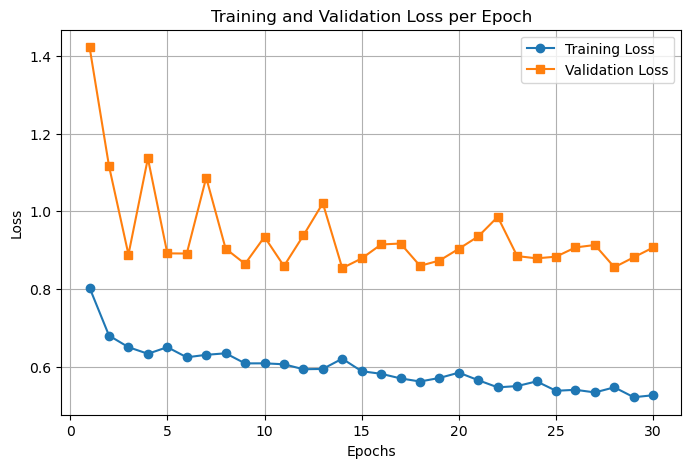

In [31]:
train(model, 
      optimizer, 
      criterion, 
      batch_size, 
      num_epochs, 
      train_set, 
      val_set, 
      device, 
      plot = True)